# Explainable AI Predicts Customer Donation Behavior

Reference: https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

In [1]:
import pandas as pd
import shap
import sklearn
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.stats import uniform, randint
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, log_loss, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import sklearn.metrics
import math
from imblearn.over_sampling import SMOTE

print(
    "shap ==",shap.__version__,
    "sklearn ==",sklearn.__version__,
    "xgboost ==",xgb.__version__
)

shap == 0.41.0 sklearn == 1.2.0 xgboost == 1.7.1


In [3]:
add = {
'Income':'Household Income (10,000 USD/year)',
'LifeGiftDol':'Dollar Amount of Lifetime Gifts', 
'LifeGiftNum':'Number of Lifetime Gifts', 
'LifeGiftPromNum':'Number of Lifetime Gifts to Promotions', 
'MinDol':'Dollar Amount of Smallest Gift', 
'MaxDol':'Dollar Amount of Largest Gift', 
'LastDol ':'Dollar Amount of Most Recent Gift',
'AvgDol':'Average Dollar Amount of Gifts', 
'Donation':'Donation'
}

path = 'Customer_Analytics_TrainTest.csv'

data = pd.read_csv(path)[list(add.keys())].dropna().rename(columns=add) 

sum(data['Donation'] == 1)/len(data)


0.050454631303456274

In [4]:
dat = data.drop(['Donation'],axis=1)
cols = list(data.drop(['Donation'],axis=1).columns)

feature_names = list(cols)
labels = data['Donation']
labels = labels.to_numpy()

smote = SMOTE()
dat, labels = smote.fit_resample(dat,labels)

train_features, test_features = train_test_split(dat, test_size=0.5,random_state=42)
train_labels, test_labels = train_test_split(labels, test_size=0.5,random_state=42)

In [5]:
param =   {'colsample_bytree': 0.9751940726386727, 'gamma': 0.0684093154594807, 'learning_rate': 0.31507120614624073, 'max_depth': 5, 'n_estimators': 148, 'subsample': 0.6740531715354479}
eval_set = [(train_features, train_labels), (test_features, test_labels)]

xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                              random_state=42,
                              colsample_bytree=param['colsample_bytree'],
                              gamma=param['gamma'],
                              learning_rate=param['learning_rate'],
                              max_depth=param['max_depth'],
                              n_estimators=param['n_estimators'],
                              subsample=param['subsample'],
                              #scale_pos_weight=c1*100,
                              booster='gbtree' # gbtree, dart, gblinear
                              )


xgb_model.fit(train_features, train_labels,
            eval_metric=["error", "logloss"],
              eval_set=eval_set,
              verbose=False)

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.9751940726386727, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0684093154594807, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.31507120614624073, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=148, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

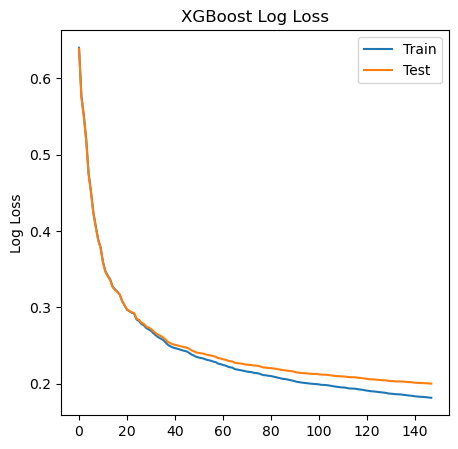

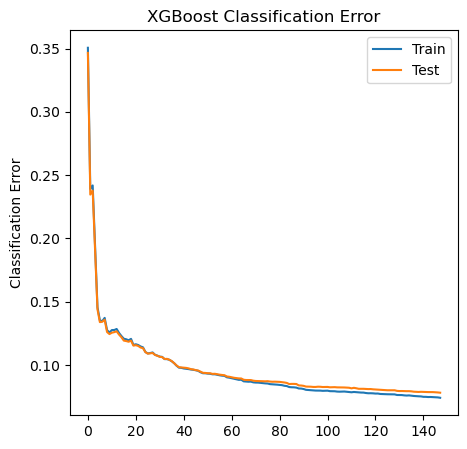

In [6]:
y_pred = xgb_model.predict(test_features)
y_pred_prob = xgb_model.predict_proba(test_features)[:, 1]

results = xgb_model.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)

# plot log loss
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
ax.plot(x_axis, results["validation_1"]["logloss"], label="Test")
ax.legend()
plt.ylabel("Log Loss")
plt.title("XGBoost Log Loss")
plt.show()
# plot classification error
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x_axis, results["validation_0"]["error"], label="Train")
ax.plot(x_axis, results["validation_1"]["error"], label="Test")
ax.legend()
plt.ylabel("Classification Error")
plt.title("XGBoost Classification Error")
plt.show()

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

from numpy import mean
scores = cross_val_score(xgb_model, train_features, train_labels, scoring='roc_auc', cv=cv, n_jobs=-1)
print("Mean ROC AUC for Training Set: %.5f" % mean(scores))

scores = cross_val_score(xgb_model, test_features, test_labels, scoring='roc_auc', cv=cv, n_jobs=-1)
print("Mean ROC AUC for Test Set: %.5f" % mean(scores))

Mean ROC AUC for Training Set: 0.96633
Mean ROC AUC for Test Set: 0.96699


In [8]:

def matrix_metrix(real_values,pred_values,beta):
   CM = confusion_matrix(real_values,pred_values,)
   TN = CM[0][0]
   FN = CM[1][0] 
   TP = CM[1][1]
   FP = CM[0][1]
   Population = TN+FN+TP+FP
   Prevalence = round( (TP+FP) / Population,2)
   Accuracy   = round( (TP+TN) / Population,4)
   Precision  = round( TP / (TP+FP),4 )
   NPV        = round( TN / (TN+FN),4 )
   PPV        = round( TP / (TP + FP),4)
   FDR        = round( FP / (TP+FP),4 )
   FOR        = round( FN / (TN+FN),4 ) 
   check_Pos  = Precision + FDR
   check_Neg  = NPV + FOR
   Recall     = round( TP / (TP+FN),4 ) # Sensitivity, True Positive Rate
   FPR        = round( FP / (TN+FP),4 )
   FNR        = round( FN / (TP+FN),4 )
   TNR        = round( TN / (TN+FP),4 ) # Specificity, True Negative Rate (1 - False Positive Rate)
   check_Pos2 = Recall + FNR
   check_Neg2 = FPR + TNR
   LRPos      = round( Recall/FPR,4 ) 
   LRNeg      = round( FNR / TNR ,4 )
   DOR        = round( LRPos/LRNeg)
   F1         = round ( 2 * ((Precision*Recall)/(Precision+Recall)),4)
   FBeta      = round ( (1+beta**2)*((Precision*Recall)/((beta**2 * Precision)+ Recall)) ,4)
   MCC        = round ( ((TP*TN)-(FP*FN))/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))  ,4)
   BM         = Recall+TNR-1
   MK         = Precision+NPV-1
   mat_met = pd.DataFrame({
'Metric':['TP','TN','FP','FN','Prevalence','Accuracy','Precision','NPV','PPV','False Discovery Rate (FDR)','False Omission Rate (FOR)','check_Pos','check_Neg','Sensitivity (TPR, Recall)','False Positive Ratio (FPR)','False Negative Ratio (FNR)','Specificity (TNR)','check_Pos2','check_Neg2','LR+','LR-','Odds Ratio','F1','FBeta','MCC','BM','MK'],     'Value':[TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,PPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LRPos,LRNeg,DOR,F1,FBeta,MCC,BM,MK]})
   return (mat_met)


matrix_metrix(test_labels, y_pred, 0.4)

,Metric,Value
0,TP,29970.0000
1,TN,34918.0000
2,FP,253.0000
3,FN,5245.0000
4,Prevalence,0.4300
5,Accuracy,0.9219
6,Precision,0.9916
7,NPV,0.8694
8,PPV,0.9916
9,False Discovery Rate (FDR),0.0084


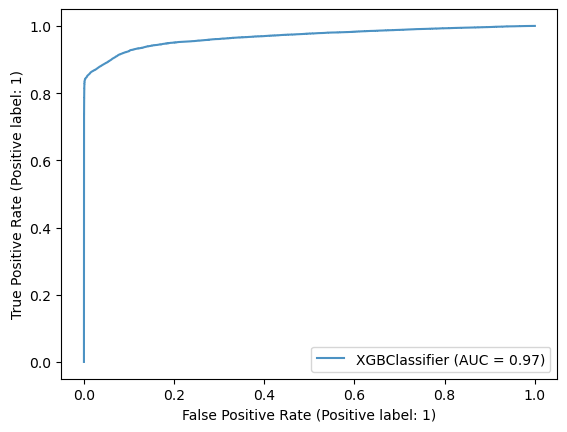

Confusion matrix, without normalization
[[34918   253]
 [ 5245 29970]]
Normalized confusion matrix
[[0.99 0.01]
 [0.15 0.85]]


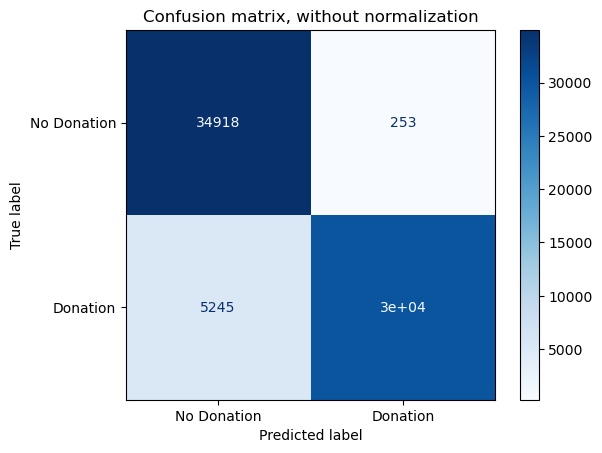

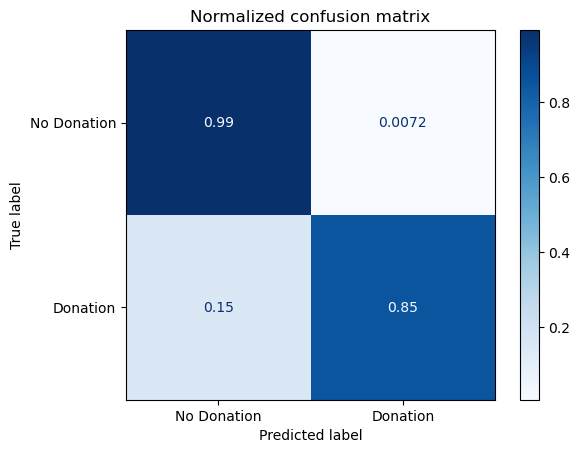

In [9]:
from sklearn.metrics import RocCurveDisplay
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(xgb_model, test_features, test_labels, ax=ax, alpha=0.8)
plt.show()


import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        xgb_model,
        test_features, 
        test_labels,
        display_labels=['No Donation','Donation'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


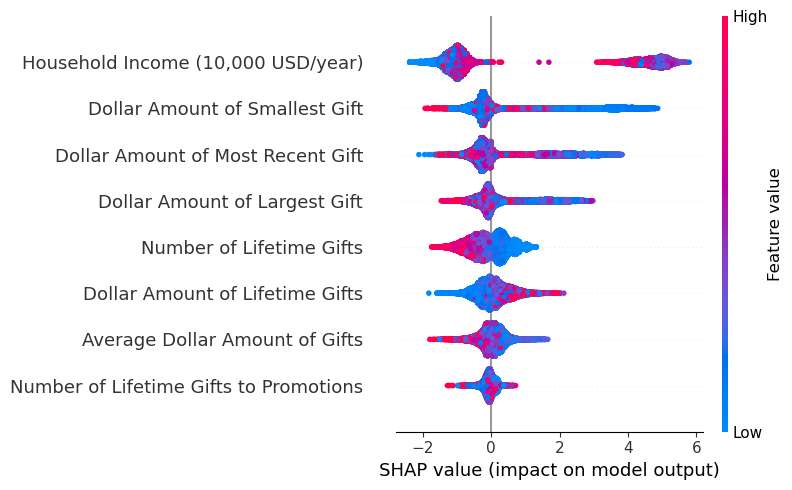

Household Income (10,000 USD/year) 0
Dollar Amount of Lifetime Gifts 1
Number of Lifetime Gifts 2
Number of Lifetime Gifts to Promotions 3
Dollar Amount of Smallest Gift 4
Dollar Amount of Largest Gift 5
Dollar Amount of Most Recent Gift 6
Average Dollar Amount of Gifts 7


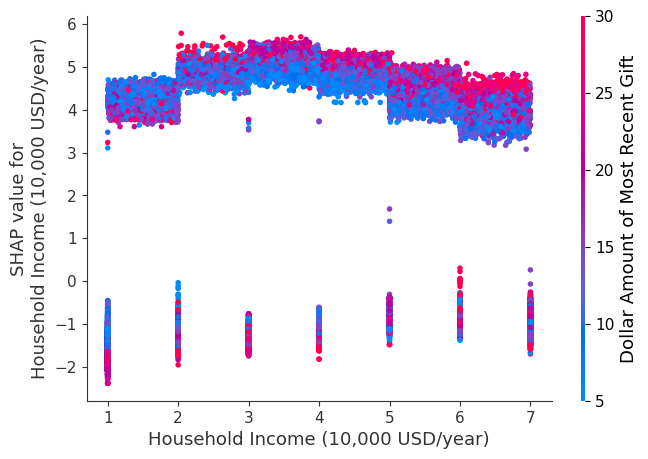

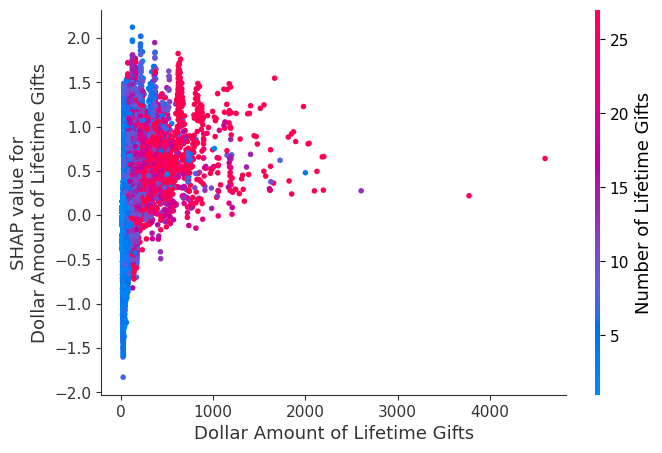

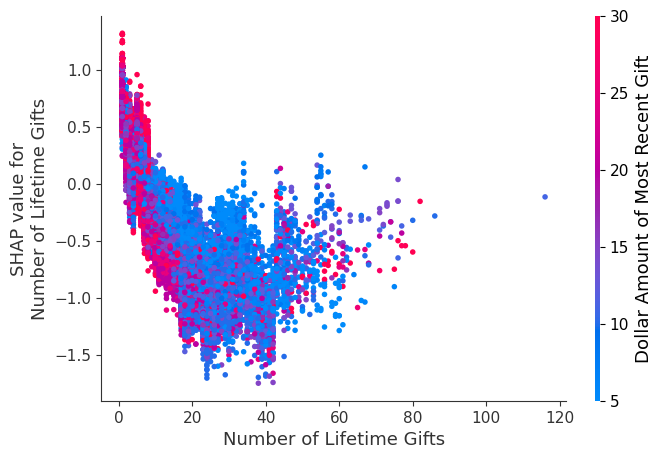

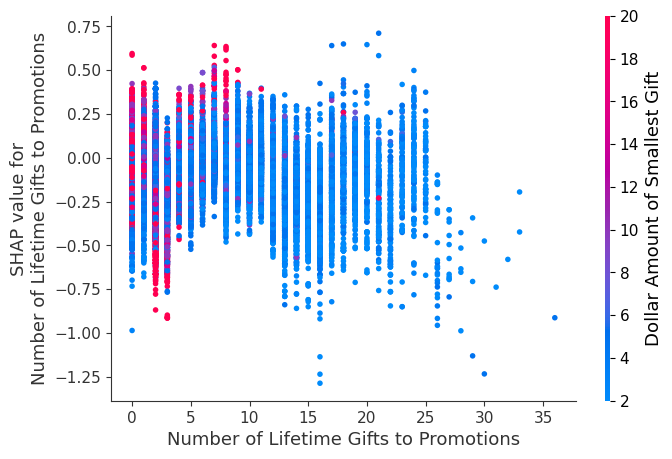

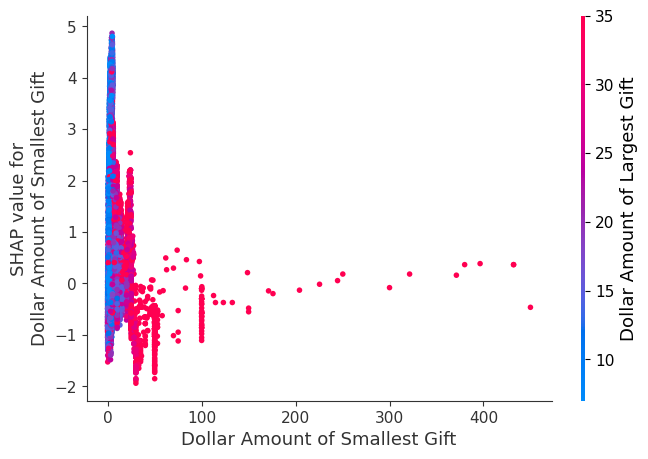

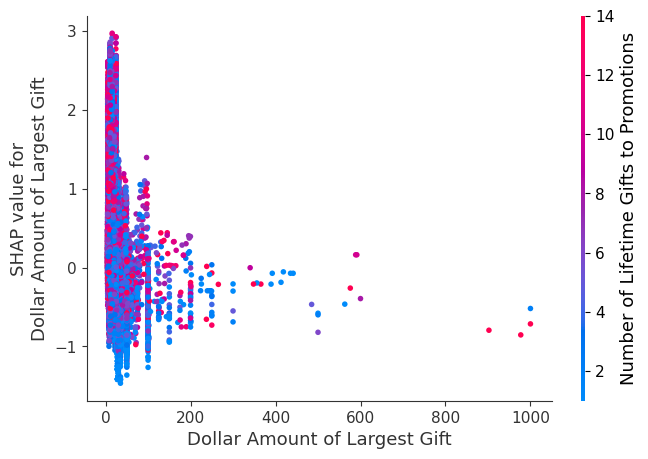

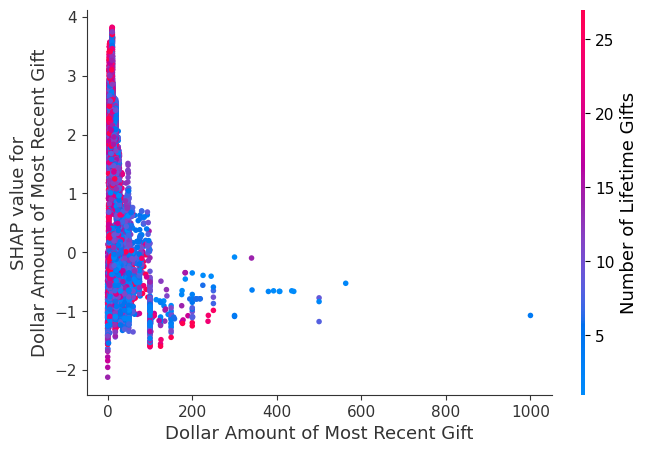

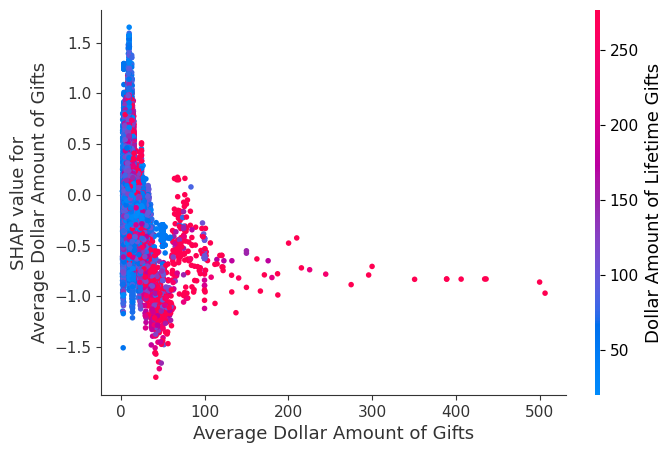

In [10]:
import time
import shap
X_sampled = pd.DataFrame(test_features, columns=feature_names)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_sampled)

# # summarize the effects of all the features
# shap.initjs()
shap.summary_plot(shap_values, X_sampled,plot_size=[8,5])


for i, col in enumerate(X_sampled.columns):
    print(col,i)
    shap.dependence_plot(col, shap_values, X_sampled, show=False)
plt.show()